seed: (-290822348, -309641686, -245492783, -115564288, 45329565, 194077398)
iteration 29/30                     


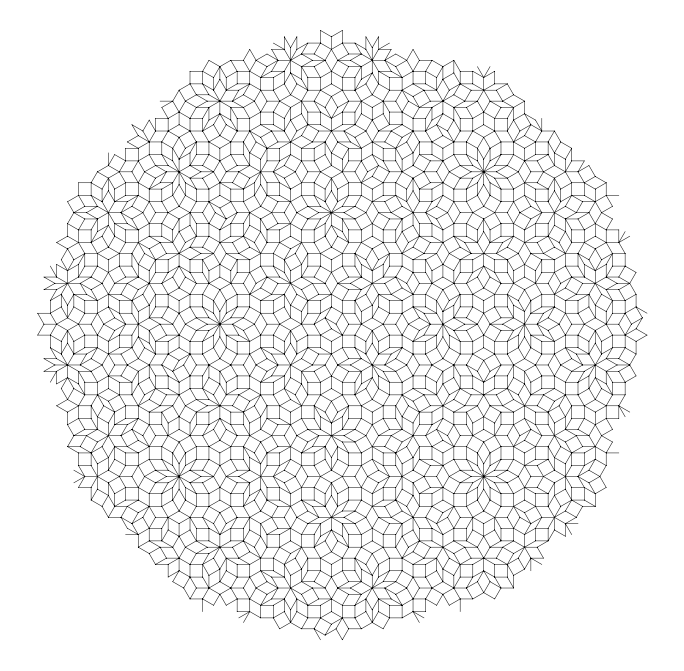

In [71]:
from scipy.spatial.distance import squareform, pdist
from pylab import *
from numpy import * 

N  = 6                     # Dimension of crystal
Ndepth = 30                 # Number of search iterations
θ  = linspace(0,pi,N+1)[1:] # Arrange basis vectors evenly on [0,π)
A  = array([cos(θ),sin(θ)]) # Convert from complex notation
Ai = pinv(A)

def plotpoints(p):
    u  = Ai.T@p
    D  = squareform(pdist(p.T))
    e  = {tuple(sorted(e)) for e in zip(*where(abs(D-1)<1e-6))}
    xy = concatenate([[u[:,a],u[:,b],[NaN,NaN]] for a,b in e])
    plot(*xy.T,lw=0.5,color='k')
    tight_layout()
    axis("equal")
    axis("off")

# Directions in which to search
D = int64(concatenate([eye(N),-eye(N)])) 

# Matrix to rotate a lattice point π/N in 2D plane
S = zeros((N,N))
S[ -1,0 ] = -1
S[:-1,1:] = eye(N-1)

# Generic caching intersection check function
# Map all points to first quadrant and memoize
def cached_crystal_checker(check):
    # Cache results to save time (memoization)
    cache = {}
    def f(q):
        # Convert test point to immutable tuple for cache key
        k = tuple(int64(q)) 
        if not k in cache:
            # Recompute intersection test if not in cache
            # Use symmetry: reduce tests to points in 1st sector
            h = angle([1,1j]@A@q)
            cache[k]=check(q) if 0<=h<=(pi/N*1.1) else f(S@q)
        return cache[k]
    f.__cache__ = cache
    return f

# Get slopes and spacing of boundary lines
m = 1/tan(θ[:-1])
d = 1/sin(θ[:-1])

@cached_crystal_checker
def intersects_cut(p,eps=1e-3,maxiter=10):
    p = int64(p)
    # Evaluate upper/lower bounds
    lp,up = p[:-1]-0.5, p[:-1]+0.5
    def feasibility_surface(p,x):
        u,l = x*m+up*d, x*m+lp*d
        y   = np.max(l)-np.min(u)
        dy  = m[argmax(l)]-m[argmin(u)]
        return y,dy
    # Initial bounds and feasability checks
    # If either bound satisfies, success
    # If better point not in bounds, fail
    x0,x1  = p[-1]-0.5, p[-1]+0.5
    y0,dy0 = feasibility_surface(p,x0)
    y1,dy1 = feasibility_surface(p,x1)
    if y0 < 0 or y1 < 0: return True
    if dy0>=0 or dy1<=0: return False
    for i in range(maxiter):
        # Guess min by following slope at bounds
        xm = (y1-y0-dy1*x1+dy0*x0)/(dy0-dy1)
        assert xm>=x0-eps
        assert xm<=x1+eps
        # Midpoint works? still feasible? 
        ym,dym = feasibility_surface(p,xm)
        if ym<0:   return True
        if dym==0: return False
        # Binary search: move inward if not done
        if dym<0:
            # If better point not in bounds, fail
            if dym>=0 or abs(x0-xm)<eps: return False
            x0,y0,dy0 = xm,ym,dym
        else:
            if dym<=0 or abs(x1-xm)<eps: return False
            x1,y1,dy1 = xm,ym,dym
    # Should have returned succes/fail before getting here
    raise RuntimeError("Maximum iterations exceeded: p=%s"%p)
    
# Random seed to nucleate crystal
seed = tuple(int64(0.5+Ai@(randint(-2**31,2**31,2))))
if not intersects_cut(seed):
    print('Seed doesn\'t intersect plane, searching nearby')
    searching = {seed}
    found = None
    for i in range(5):
        to_add    = set()
        to_search = {tuple(q) for p in searching for q in D+p}
        for q in to_search:
            if intersects_cut(q):
                found = q
                break
            else:
                to_add.add(q)
        searching |= to_add
    if found is None:
        print('Could not find a valid seed')
        assert 0
    else:
        seed = tuple(found)

print('seed:',seed)
    
# Start with a seed point at zero and build outwards
# Iteratively search in each direction to add points
Q = {seed}
allQ = set() 
for i in range(Ndepth):
    Q = {tuple(q) for p in Q for q in D+p if intersects_cut(q)}-allQ
    allQ |= Q
    print('\riteration %d/%d'%(i,Ndepth),' '*20,end='',flush=True)
print('')

figure(figsize=(10,10))
plotpoints(array(list(allQ)).T)